THE library , usage and clear instructions can be found at https://georgebv.github.io/pyextremes/quickstart/

In [24]:
import os
import sys
sys.path.append('../Prelim_Stats')
import config
import numpy as np
import xarray as xr
import pyproj
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import probplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import multivariate_normal
from pyproj import Transformer
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

In [25]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import plot_mean_residual_life
from closest_grid_cell import select_nearest_grid_cell
from pyextremes import plot_parameter_stability
from pyextremes import plot_return_value_stability

Threshold selection : based on Mean Residual Life (https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/)

#Estimation of Mean Residual life

In [14]:
data_hr_precip= (xr.open_dataset(f'{config.TARGET_DIR}/RhiresD_1971_2023.nc').sel(time=slice('1981-01-01', '2010-12-31')))

In [15]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [16]:
data_hr_precip_locarno = select_nearest_grid_cell(data_hr_precip, target_lat, target_lon, 'RhiresD')

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14


In [17]:
precip_series_hr_pd= data_hr_precip_locarno['data'].to_pandas()

Ways of chosing a threshold : MRL (1)

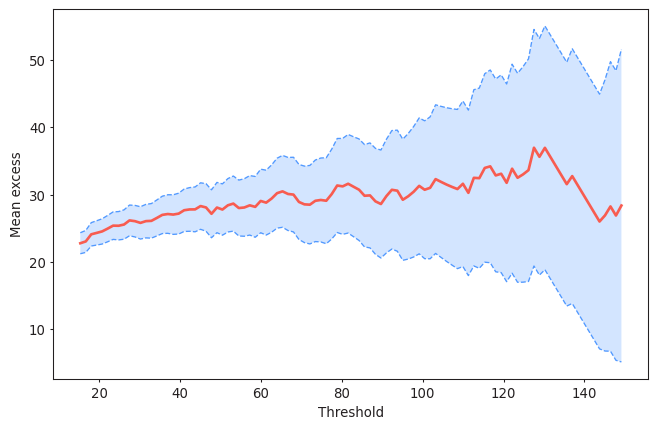

In [18]:
plot_mean_residual_life(precip_series_hr_pd)
plt.show() #MRL is the least useful as it is visually subjective

Method II : Parametric Stability 

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

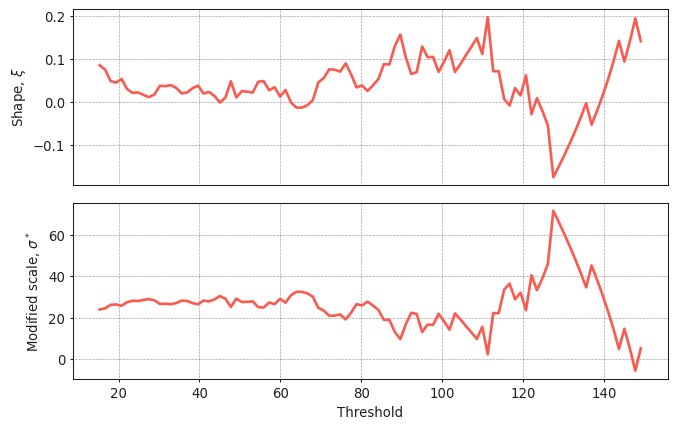

In [19]:
plot_parameter_stability(precip_series_hr_pd) #Stabilises around 60 mm as the threshold and the higher variance with increasing threshold 

Method III : extension of Method II : return value stability 

Return value stability for 10-year return level:
Return value stability for 25-year return level:
Return value stability for 50-year return level:
Return value stability for 100-year return level:


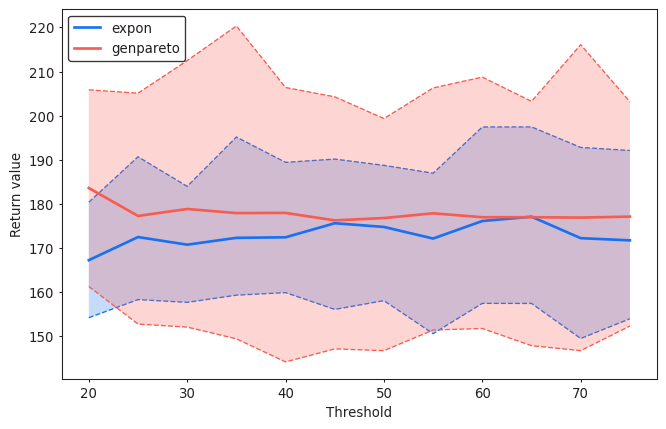

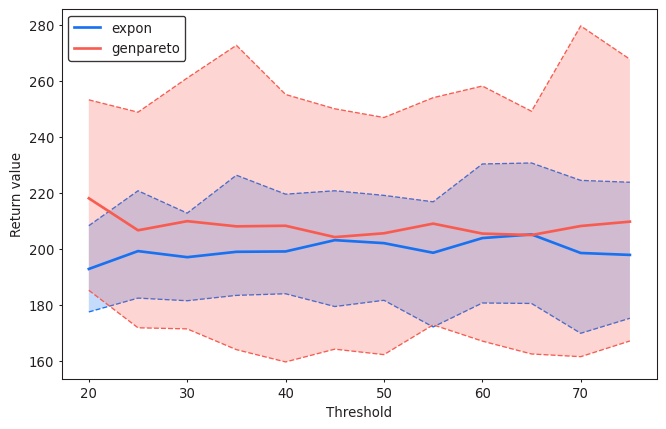

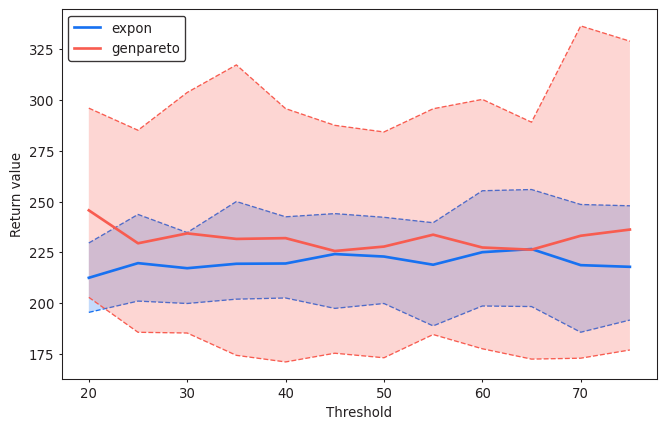

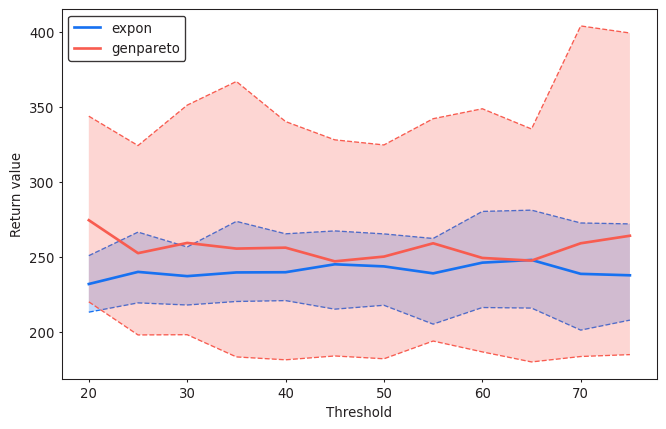

In [46]:
for i, period in enumerate([10, 25, 50,100]):
    print(f"Return value stability for {period}-year return level:")
    plot_return_value_stability(precip_series_hr_pd, 
                                return_period=period, 
                                thresholds= np.arange(20,80,5),
                                alpha=0.95,)
    

#Return value : the amount to be exceeded every 

Threshold value of around 70 mm/day was selected for precip. Based on methods 1 and II!

In [21]:
from pyextremes import get_extremes, get_return_periods, EVA

In [59]:
gpd_precip_pot_model = EVA(precip_series_hr_pd)
extremes_pr= gpd_precip_pot_model.get_extremes(method="POT",
                                              threshold=70, #in mm/day
                               )

In [64]:
gpd_precip_pot_model.fit_model()


In [65]:
gpd_precip_pot_model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                       RhiresD      Size:                              10,957
Start:                       January 1981      End:                        December 2010
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                104      Extraction method:                    POT
Type:                                high      Threshold:                             70
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Visualising fit quality for Locarno POT GEV


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='RhiresD'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='RhiresD', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

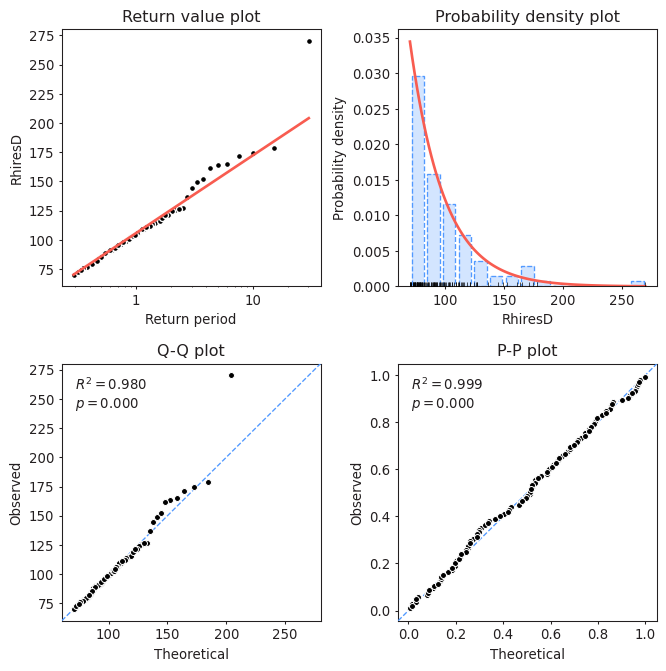

In [66]:
print("Visualising fit quality for Locarno POT GEV")
gpd_precip_pot_model.plot_diagnostic()

MODEL SUMMARY for return periods 

In [67]:
gpd_precip_pot_model_summary = gpd_precip_pot_model.get_summary(
    return_period=[10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)

In [68]:
print(gpd_precip_pot_model_summary)

               return value    lower ci    upper ci
return period                                      
10.0             172.248482  152.147402  194.256789
25.0             198.670398  173.375019  226.365847
50.0             218.657805  189.433092  250.655411
100.0            238.645212  205.491165  274.944975


GETTING ENTIRE ANNUAL RETURN PERIOD TABLE

In [69]:
return_periods_precip_pot = get_return_periods(ts=precip_series_hr_pd,
                                              extremes= gpd_precip_pot_model.extremes,
                                              extremes_method='POT', 
                                              extremes_type="high",
                                              return_period_size="365D",
                                              plotting_position="median")

In [70]:
print(return_periods_precip_pot)

               RhiresD  exceedance probability  return period
time                                                         
1981-03-30   90.686699                0.504791       0.571761
1981-05-25   88.449150                0.543118       0.531412
1981-07-23   90.763145                0.495209       0.582824
1981-09-21  163.689331                0.054448       5.300798
1982-06-11  100.177704                0.341901       0.844161
...                ...                     ...            ...
2009-07-31   70.376137                0.983879       0.293349
2010-05-02   75.920914                0.820989       0.351551
2010-06-16   72.615974                0.916806       0.314810
2010-10-31   81.859123                0.629354       0.458597
2010-11-15   74.514664                0.849734       0.339659

[104 rows x 3 columns]


                                              xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

REPEATING THE SAME EXERCISE FOR TEMPERATURE 

In [71]:
data_hr_temp=xr.open_dataset(f"{config.TARGET_DIR}/TabsD_1971_2023.nc")
data_hr_temp= data_hr_temp.sel(time=slice('1981-01-01', '2010-12-31'))

In [72]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [73]:
data_hr_temp_locarno = select_nearest_grid_cell(data_hr_temp, target_lat, target_lon, 'TabsD')

temp_series_hr = data_hr_temp_locarno['data']
lat_idx = data_hr_temp_locarno['lat_idx']
lon_idx = data_hr_temp_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'TabsD' extracted
Time series shape: (10957,)
Data range: -7.54 to 29.23


In [74]:
temp_series_hr_pd= temp_series_hr.to_pandas()

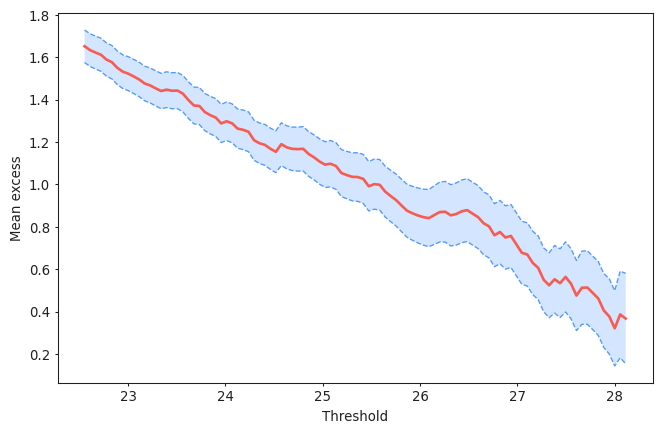

In [34]:
plot_mean_residual_life(temp_series_hr_pd)
plt.show()

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

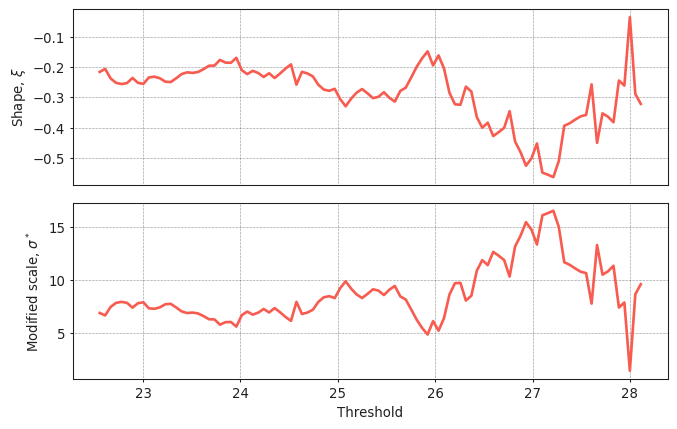

In [35]:
plot_parameter_stability(temp_series_hr_pd) #Stabilises around 25 degrees as the threshold and the higher variance with increasing threshold

#return value stability

Return value stability for 10-year return level:


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Return value stability for 50-year return level:
Return value stability for 100-year return level:


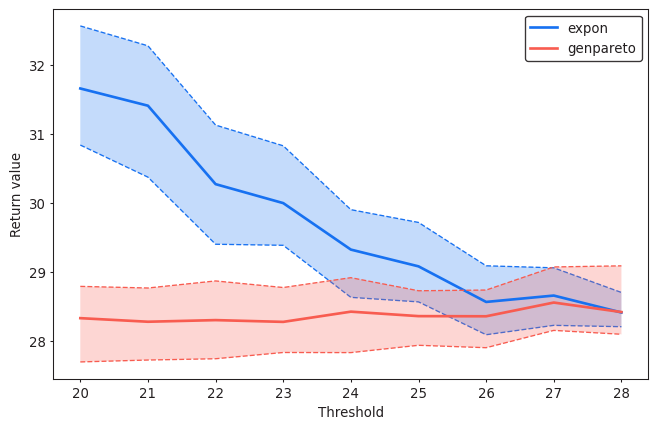

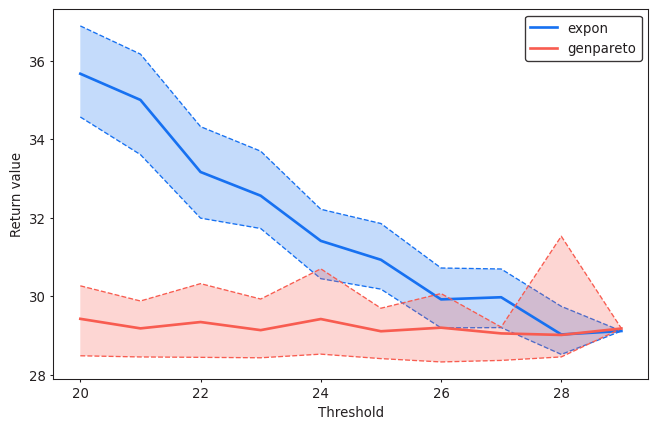

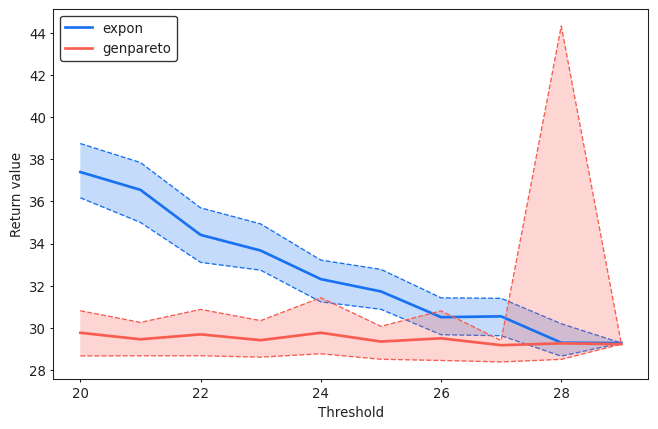

In [36]:
for i, period in enumerate([10,50,100]):
    print(f"Return value stability for {period}-year return level:")
    plot_return_value_stability(temp_series_hr_pd, 
                                return_period=period, 
                                thresholds= np.arange(20,30,1),
                                alpha=0.95,)
    

#Return value : the amount to be exceeded every 

In [26]:
from pyextremes import get_extremes, get_return_periods, EVA

In [75]:
gpd_temp_pot_model = EVA(temp_series_hr_pd)
extremes_temp= gpd_temp_pot_model.get_extremes(method="POT",
                                              threshold=25, #in degrees C
                               )

In [76]:
gpd_temp_pot_model.fit_model()
gpd_temp_pot_model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                         TabsD      Size:                              10,957
Start:                       January 1981      End:                        December 2010
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                106      Extraction method:                    POT
Type:                                high      Threshold:                             25
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Visualising fit quality for Locarno POT GPD


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='TabsD'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='TabsD', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

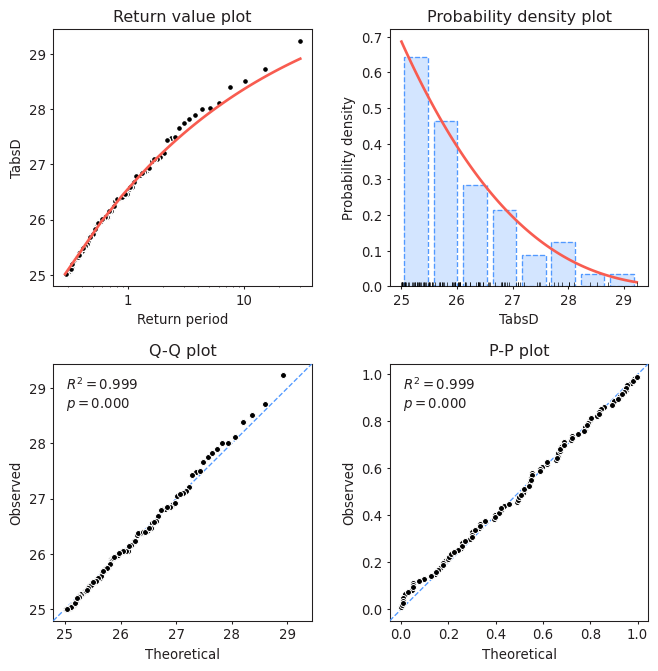

In [77]:
print("Visualising fit quality for Locarno POT GPD")
gpd_temp_pot_model.plot_diagnostic()

MODEL SUMMARY for return periods 

In [78]:
gpd_temp_pot_model_summary = gpd_temp_pot_model.get_summary(
    return_period=[10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)

In [79]:
print(gpd_temp_pot_model_summary)

               return value   lower ci   upper ci
return period                                    
10.0              28.365418  27.870959  28.751455
25.0              28.828945  28.195914  29.338282
50.0              29.112353  28.370719  29.757543
100.0             29.348490  28.473799  30.190617


In [80]:
return_periods_temp_pot = get_return_periods(ts=temp_series_hr_pd,
                                              extremes= gpd_temp_pot_model.extremes,
                                              extremes_method='POT', 
                                              extremes_type="high",
                                              return_period_size="365D",
                                              plotting_position="median")

In [81]:
print(return_periods_temp_pot)
#Sort highest to lowest return level


                TabsD  exceedance probability  return period
time                                                        
1981-06-13  26.561661                0.279063       1.014732
1981-06-15  25.001617                0.993583       0.285003
1981-08-05  25.004642                0.984182       0.287725
1982-07-07  26.378954                0.344874       0.821094
1983-07-13  25.967516                0.495299       0.571723
...               ...                     ...            ...
2009-08-24  25.223873                0.843158       0.335849
2010-06-28  25.194910                0.861961       0.328523
2010-07-01  25.492132                0.692733       0.408778
2010-07-05  26.928019                0.185047       1.530283
2010-07-16  27.816792                0.081629       3.469024

[106 rows x 3 columns]


In [45]:
#Sorting lowest to highest 
return_periods_temp_pot = return_periods_temp_pot.sort_values(by="return period", ascending=True)
print(return_periods_temp_pot)

                TabsD  exceedance probability  return period
time                                                        
2004-06-29  26.018490                0.989396       0.474033
1989-07-26  26.025274                0.973860       0.481596
1998-08-10  26.029322                0.958324       0.489403
2001-08-01  26.044397                0.942787       0.497468
1984-07-14  26.045837                0.927251       0.505804
...               ...                     ...            ...
2003-07-13  28.112059                0.072749       6.446904
2003-06-12  28.391733                0.057213       8.197590
2003-06-26  28.515810                0.041676      11.253542
1983-07-21  28.718632                0.026140      17.942125
2003-08-11  29.231388                0.010604      44.230954

[64 rows x 3 columns]


COnverted into a function based on thresholds and return levels to calculate biases of return levels. 

In [27]:
from major_return_levels_pot import get_extreme_return_levels

Observational reference 

Doing it for EQM coarse, bicubic and UNet downscaled precip and temperature

#Coarse

In [28]:
# Specify the return periods
return_periods = [5, 10, 20, 50, 100]

# Get return levels for observations and each baseline
obs_rl = get_extreme_return_levels(
    nc_file=f"{config.TARGET_DIR}/RhiresD_1971_2023.nc",
    variable_name="RhiresD",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

coarse_rl = get_extreme_return_levels(
    nc_file=f"{config.MODELS_DIR}/precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099/precip_r01_coarse_masked.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

eqm_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/precip_BC_bicubic_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

eqm_unet_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/DOWNSCALED_TRAINING_QM_BC_precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

dotc_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/precip_temp_tmin_tmax_bicubic_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

dotc_unet_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/DOWNSCALED_TRAINING_DOTC_BC_precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

qdm_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/precip_BC_bicubic_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

qdm_unet_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/DOWNSCALED_TRAINING_QDM_BC_precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    threshold=70,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

# Calculate bias/error for each baseline
baselines = {
    "COARSE": coarse_rl,
    "EQM": eqm_rl,
    "EQM_UNET": eqm_unet_rl,
    "DOTC": dotc_rl,
    "DOTC_UNET": dotc_unet_rl,
    "QDM": qdm_rl,
    "QDM_UNET": qdm_unet_rl
}

bias_table = pd.DataFrame(index=return_periods)
for name, rl in baselines.items():
    bias_table[name] = rl - obs_rl

print("Bias (Model - Obs) for each return period (POT) for precip (Locarno):")
print(bias_table)

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14
Target: (46.1709, 8.7995)
Closest grid cell: (46.1639, 8.8693)
Distance: 0.0701 degrees
Grid indices: lat_idx=4, lon_idx=21
Variable 'precip' extracted
Time series shape: (10957,)
Data range: -0.20 to 272.01
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'precip' extracted
Time series shape: (10957,)
Data range: -0.25 to 265.47
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'precip' extracted
Time series shape: (10957,)
Data range: 0.00 to 264.85
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'precip' extracted
Time ser

Tmax

In [29]:
return_periods = [5, 10, 20, 50, 100]

# Get return levels for observations and each baseline
obs_rl = get_extreme_return_levels(
    nc_file=f"{config.TARGET_DIR}/TmaxD_1971_2023.nc",
    variable_name="TmaxD",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

coarse_rl = get_extreme_return_levels(
    nc_file=f"{config.MODELS_DIR}/tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099/tmax_r01_coarse_masked.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

eqm_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/tmax_BC_bicubic_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

eqm_unet_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/DOWNSCALED_TRAINING_QM_BC_tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

dotc_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/precip_temp_tmin_tmax_bicubic_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

dotc_unet_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/DOWNSCALED_TRAINING_DOTC_BC_tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

qdm_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/tmax_BC_bicubic_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

qdm_unet_rl = get_extreme_return_levels(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/DOWNSCALED_TRAINING_QDM_BC_tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    threshold=25,
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

# Bias/error for each baseline
baselines = {
    "COARSE": coarse_rl,
    "EQM": eqm_rl,
    "EQM_UNET": eqm_unet_rl,
    "DOTC": dotc_rl,
    "DOTC_UNET": dotc_unet_rl,
    "QDM": qdm_rl,
    "QDM_UNET": qdm_unet_rl
}

bias_table = pd.DataFrame(index=return_periods)
for name, rl in baselines.items():
    bias_table[name] = rl - obs_rl

print("Bias (Model - Obs) for each return period (POT) for tmax (Locarno):")
print(bias_table)

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'TmaxD' extracted
Time series shape: (10957,)
Data range: -3.40 to 37.58
Target: (46.1709, 8.7995)
Closest grid cell: (46.1639, 8.8693)
Distance: 0.0701 degrees
Grid indices: lat_idx=4, lon_idx=21
Variable 'tmax' extracted
Time series shape: (10957,)
Data range: -12.70 to 31.79
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'tmax' extracted
Time series shape: (10957,)
Data range: -9.99 to 34.63
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'tmax' extracted
Time series shape: (10957,)
Data range: -6.41 to 37.75
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'tmax' extracted
Time series shape: (